# Setup - set general parameters

In [25]:

############Centroiding Parametesr###############

#thresholds for spot detection (*std)
findSigma=50     #sigma of threshold for finding spots
centSigma=15     #sigma of threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=10    #size of box for finding spots
boxCent=6     #size of box for centroiding
nmin=10       #minimum number of acceptable pixels in a spot
nmax=90       #maximum number of acceptable pixels in a spot
maxIt=20      #maximum number of iterations for centroiding

#set to non zero to override automatic fwhm determination. 
fwhmx=0
fwhmy=0

sigmaThresh = 4
threshFact = 2

##############Various Flags####################

#inter = 1 for notebook, 0 for scripts, cenFlag='local' for local, 'db' to read from database
inter=1
cenFlag='local'
#cenFlag='db'

#dataSource - set to 'pinhole' for pinhole mask, 'taichung' for lab data. 

dataType='pinhole'

#conifguration for rotator center

config="calib"

#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [26]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys

#kludge - need to change???
sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp
import DistortionCoefficients
from importlib import reload  #for debugging purposes

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis

try:
    import mcsActor.Visualization.plotRoutines as visplot
except:
    import plotRoutines as visplot




# connect to database (not done in calib mode)

In [7]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    
#read instrument parameters if available
if(config != "calib"):
    rotCent,offset=vis.loadInstParams(config)


# set image parameters

In [71]:

#set frame ID minimum and maximum values (inclusive)

frameID=8673

#source directory data files in local mode
sourceDir="/Users/karr/ics_mcsActor/python/mcsActor/Visualization/"
#sourceDir=""
fPref="PFSC"

#subtitle for plots - currently set to first frame ID plus tag
stitle=""

moveID=0
#get list of file names
fname,prefix=vis.getFileName(frameID,moveID,sourceDir,fPref,dataType='pinhole')
#fname="/Users/karr/NewData/20190809_adj8.fits"
#fname="20190812_adj6.fits"
#prefix='adj6'
#load the image

image=vis.getImage(fname)


# calculate threshold values and region (once per config, if calculating locally)

Thresholds= 3390.7881664387874 1886.9553405244314
Boundaries of region (x1,x2,y1,y2):  18 3876 2507 6438


<IPython.core.display.Javascript object>


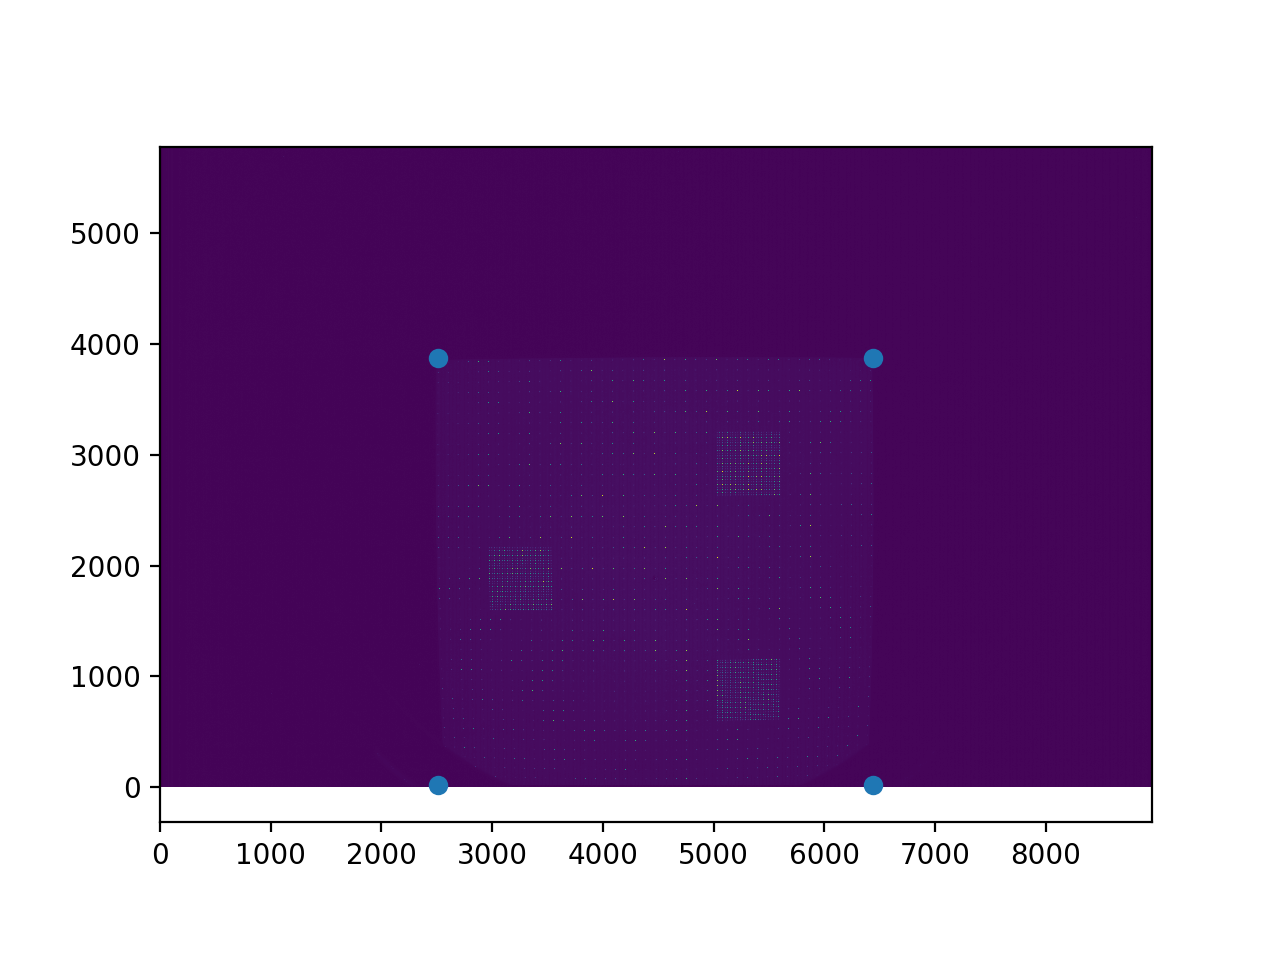

1886.9553405244314 3390.7881664387874


In [72]:
#not needed if pulling from DB
reload(vis)
reload(fps)
reload(mcs)

if((cenFlag=='local')):
    
    #if config is not known, find the region (must be rotate by multiple of 90 degrees)
    if(config=='calib'):
        findThresh,centThresh,xrange,yrange=mcs.getThresh(image,'calib',sigmaThresh,threshFact,findSigma,centSigma)
        
    #if config is known, calculate the region for the threshold from the coord transforms
    else:
        thresh1,thresh2,xrange,yrange=mcs.getThresh(image,'fieldID',sigmaThresh,threshFact,findSigma,centSigma,fibrePos=fibrePos)
        

print("Thresholds=",findThresh,centThresh)
print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])

#yrange[0]=2503
#xrange[0]=1900
#xrange[0]=2000

#a=mcs.getManualThresh(image,xrange,yrange,sigmaThresh)
#findThresh=a.mean()+a.std()*findSigma
#centThresh=a.mean()+a.std()*centSigma
#print(findThresh,centThresh)
#visplot.checkThreshold(image,xrange,yrange)
#yrange=[2810,6771]
#xrange=[1943,5729]
#yrange=[2518,6455]
#xrange=[1850,5729]
visplot.checkThreshold(image,xrange,yrange)
a=mcs.getManualThresh(image,xrange,yrange,sigmaThresh)
findThresh=a.mean()+a.std()*findSigma
centThresh=a.mean()+a.std()*centSigma
print(centThresh,findThresh)

# Do the centroiding for a set of database, either locally or retrieve from DB


<IPython.core.display.Javascript object>


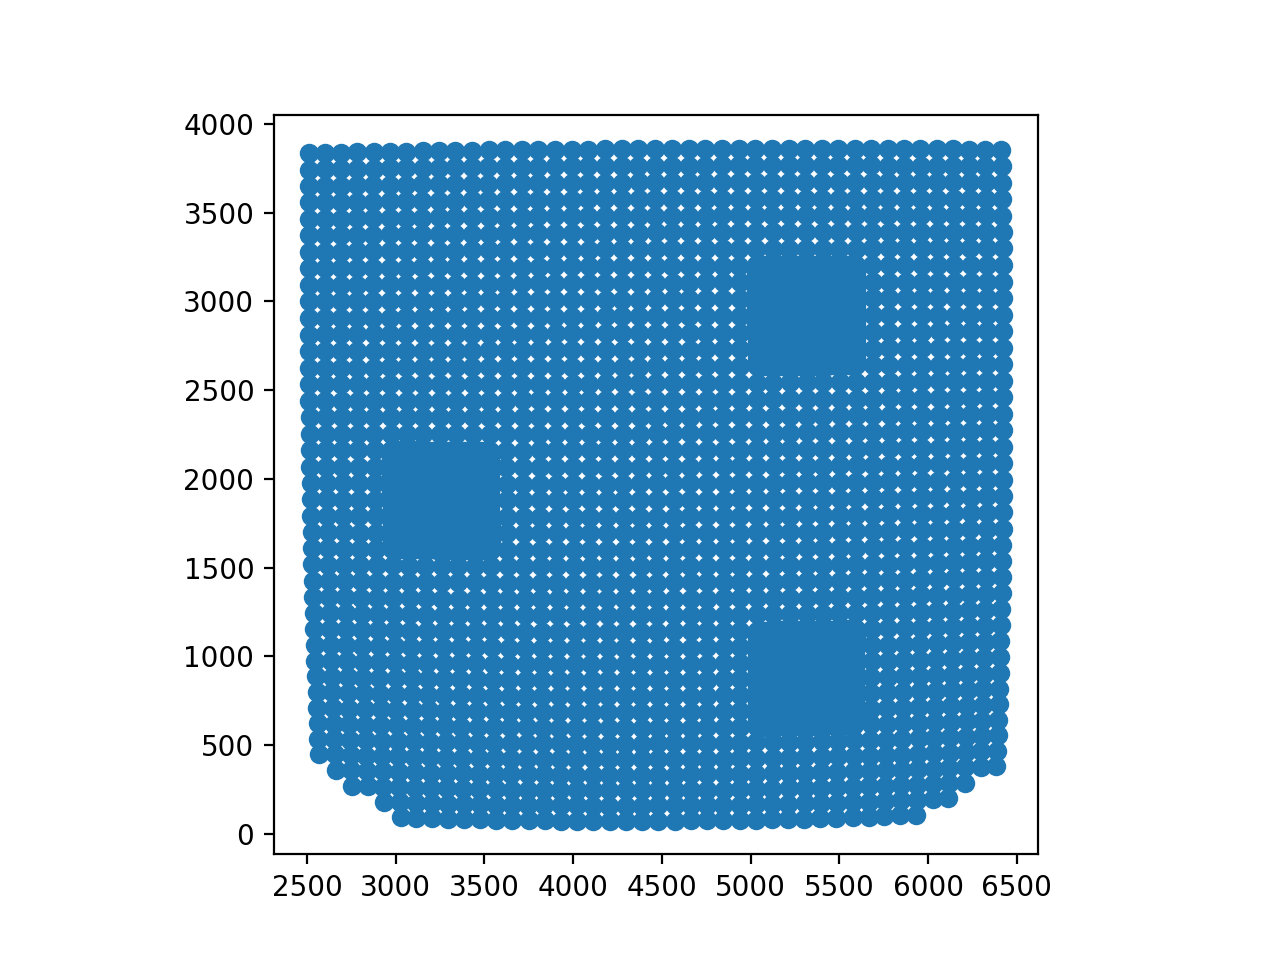

In [73]:
reload(vis)
reload(visplot)

redo=1 #flag to calculate the centroids

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):
    centroids=vis.getCentroids(image,findThresh,centThresh,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)

#db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=vis.getCentroidsDB(conn,frameID)        

#some assignments, for easier plotting
x=centroids[:,1]
y=centroids[:,2]
fx=centroids[:,3]    
fy=centroids[:,4]
peak=centroids[:,5]
back=centroids[:,6]
    
#plot the centroids for a quick check
visplot.checkCentroids(x,y,1,prefix,inter)



# Image Quality Plots


Plots of FWHM values, peak values. Change "plotRange" to adjust the range. 


<IPython.core.display.Javascript object>


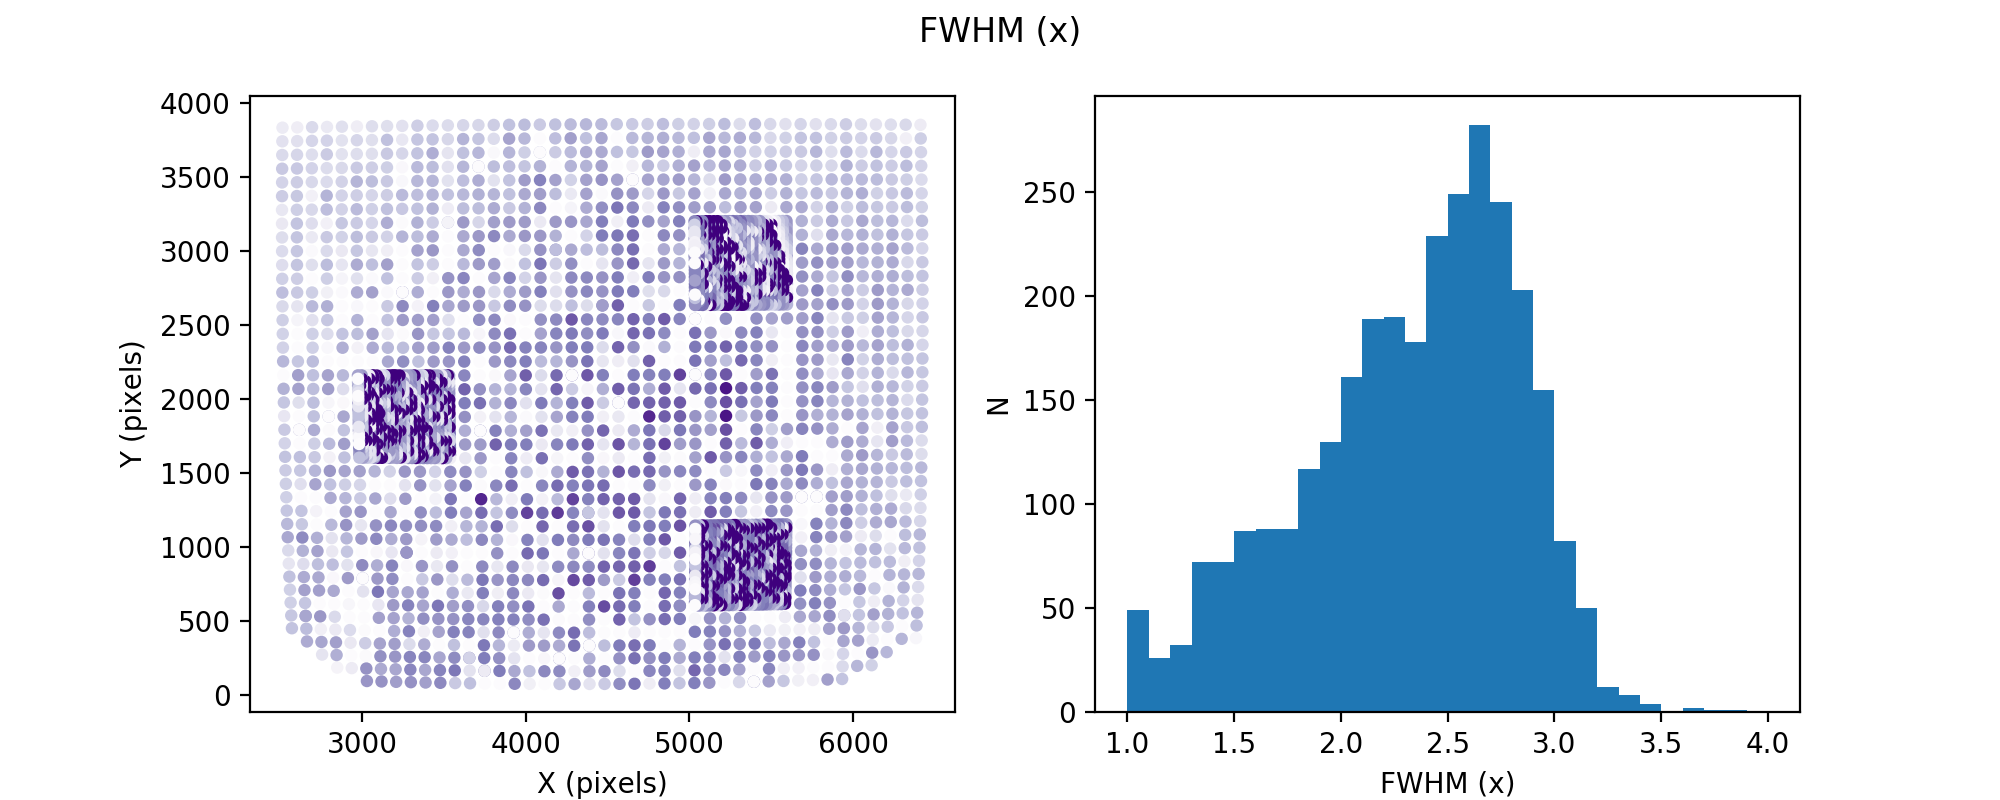

<IPython.core.display.Javascript object>


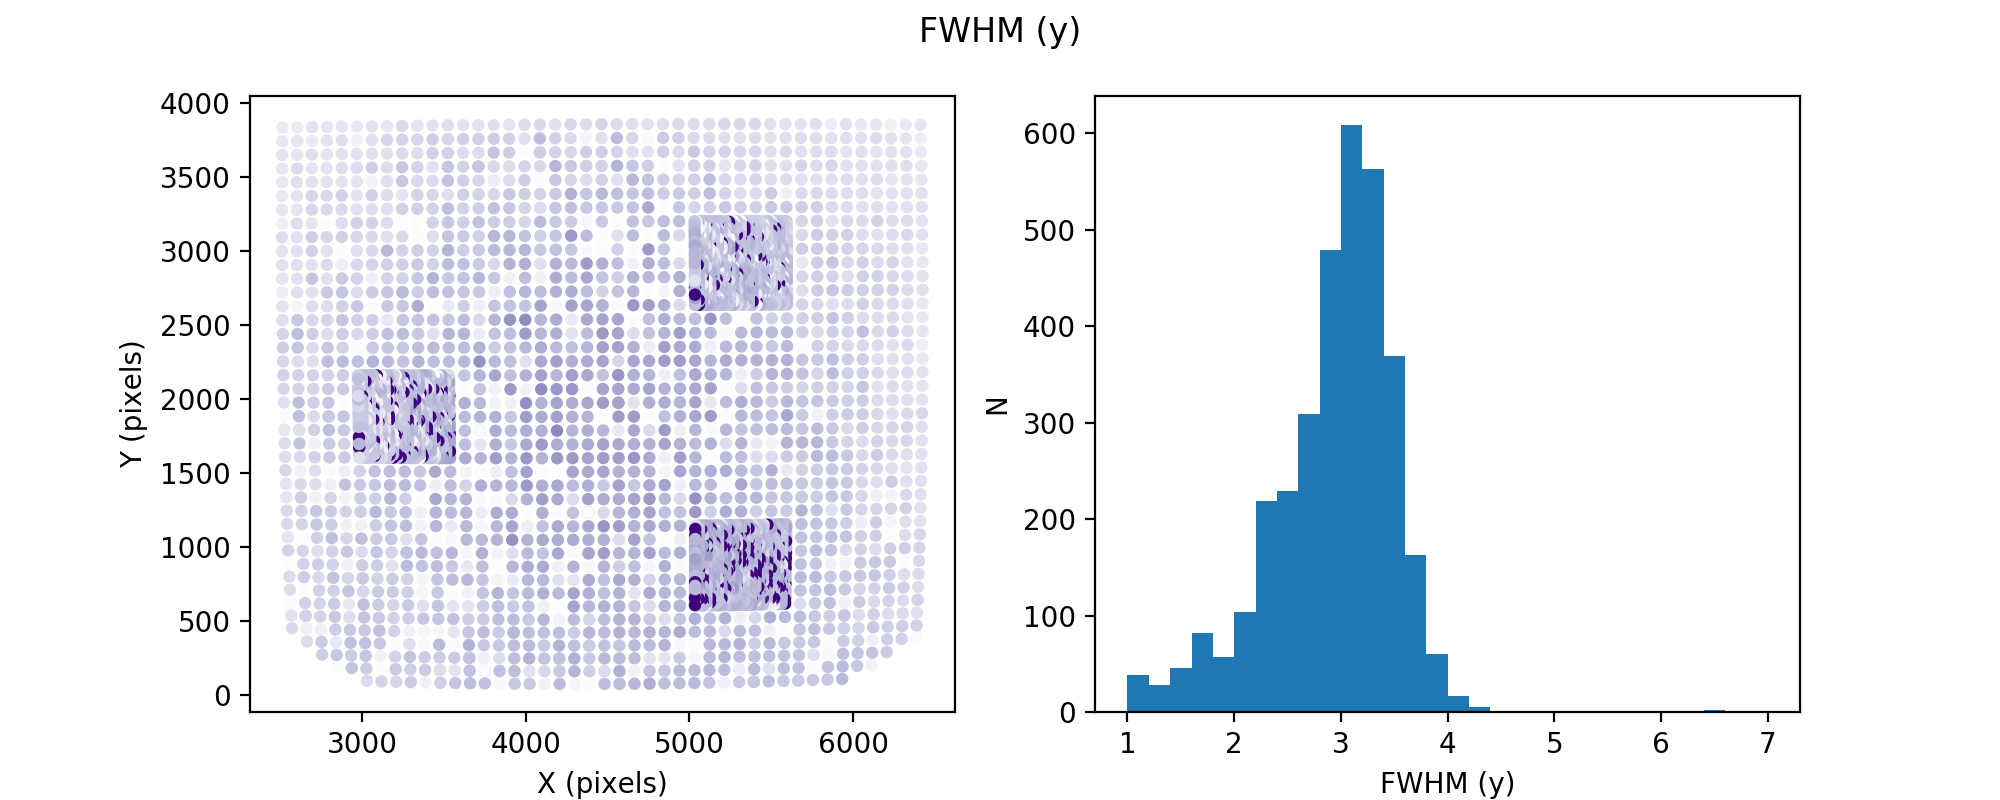

<IPython.core.display.Javascript object>


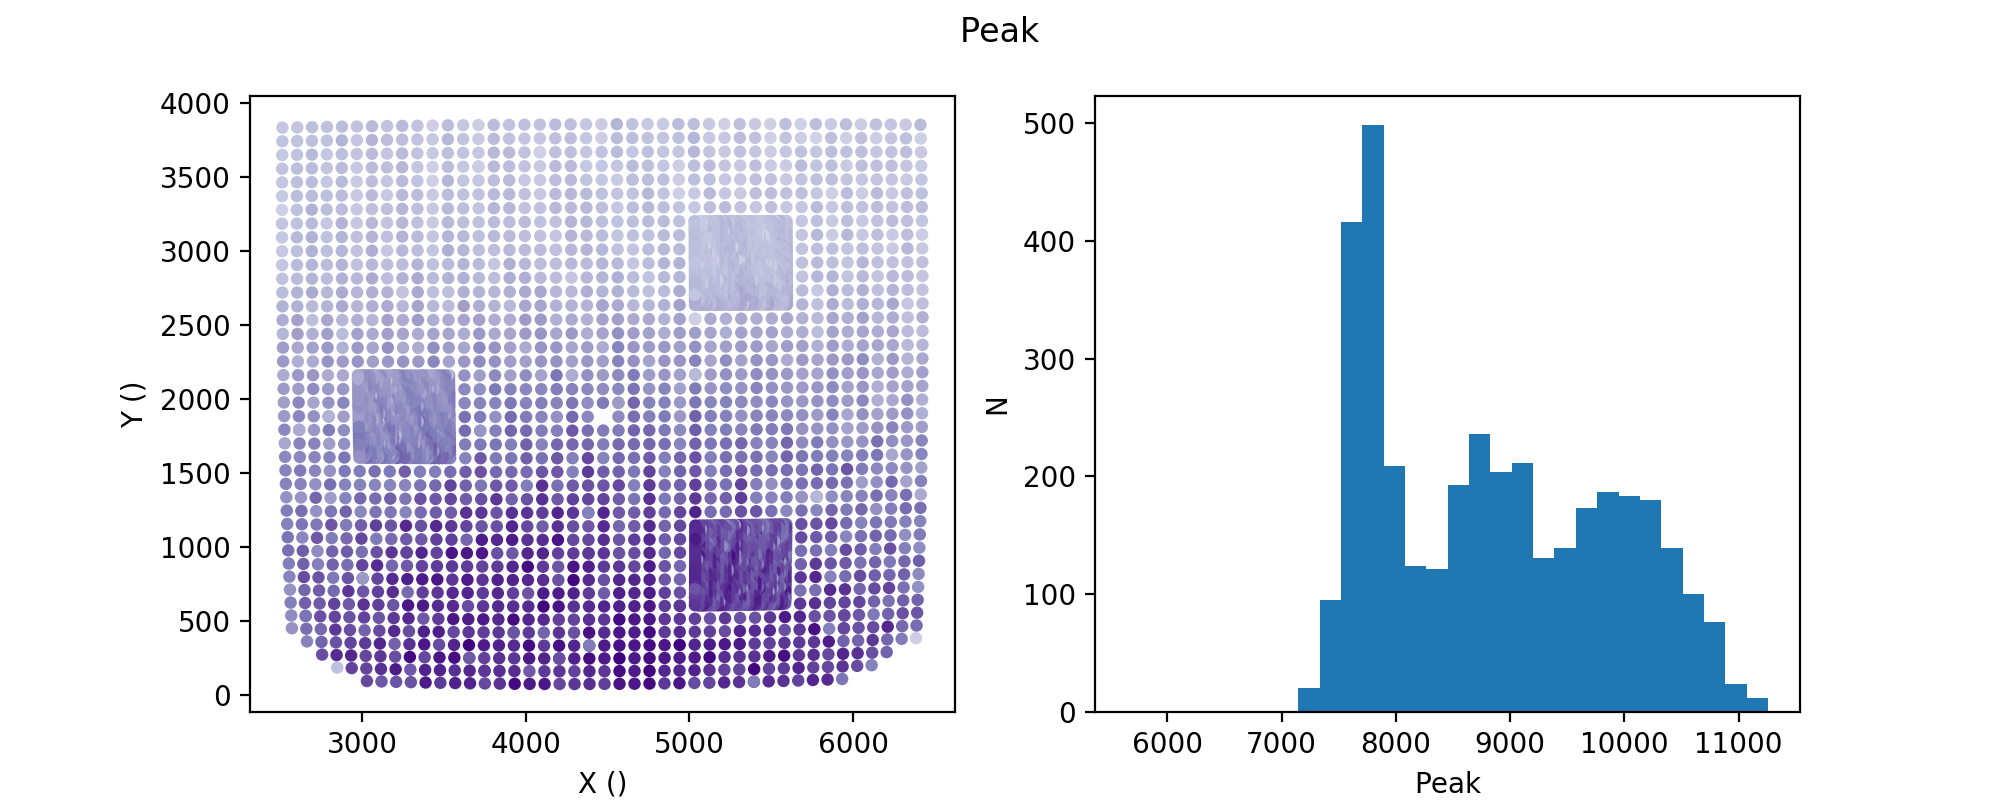

In [48]:
reload(visplot)

nbins=30

#set the ranges nad call the plotting routine. 

#FWHMs
plotRange=[1,4]
visplot.pairPlot(x,y,fx,fx,plotRange,"FWHM (x)",prefix,"_fwhmx","FWHM (x)","pixels",nbins,inter,stitle=stitle)
plotRange=[1,7]
visplot.pairPlot(x,y,fy,fy,plotRange,"FWHM (y)",prefix,"_fwhmy","FWHM (y)","pixels",nbins,inter,stitle=stitle)

#peak values
plotRange=[peak.min(),peak.max()]
visplot.pairPlot(x,y,peak,peak,plotRange,"Peak",prefix,"_peak","Peak","",nbins,inter,stitle=stitle)


## Miscellaneous Routines that might be useful


### plot image



<IPython.core.display.Javascript object>


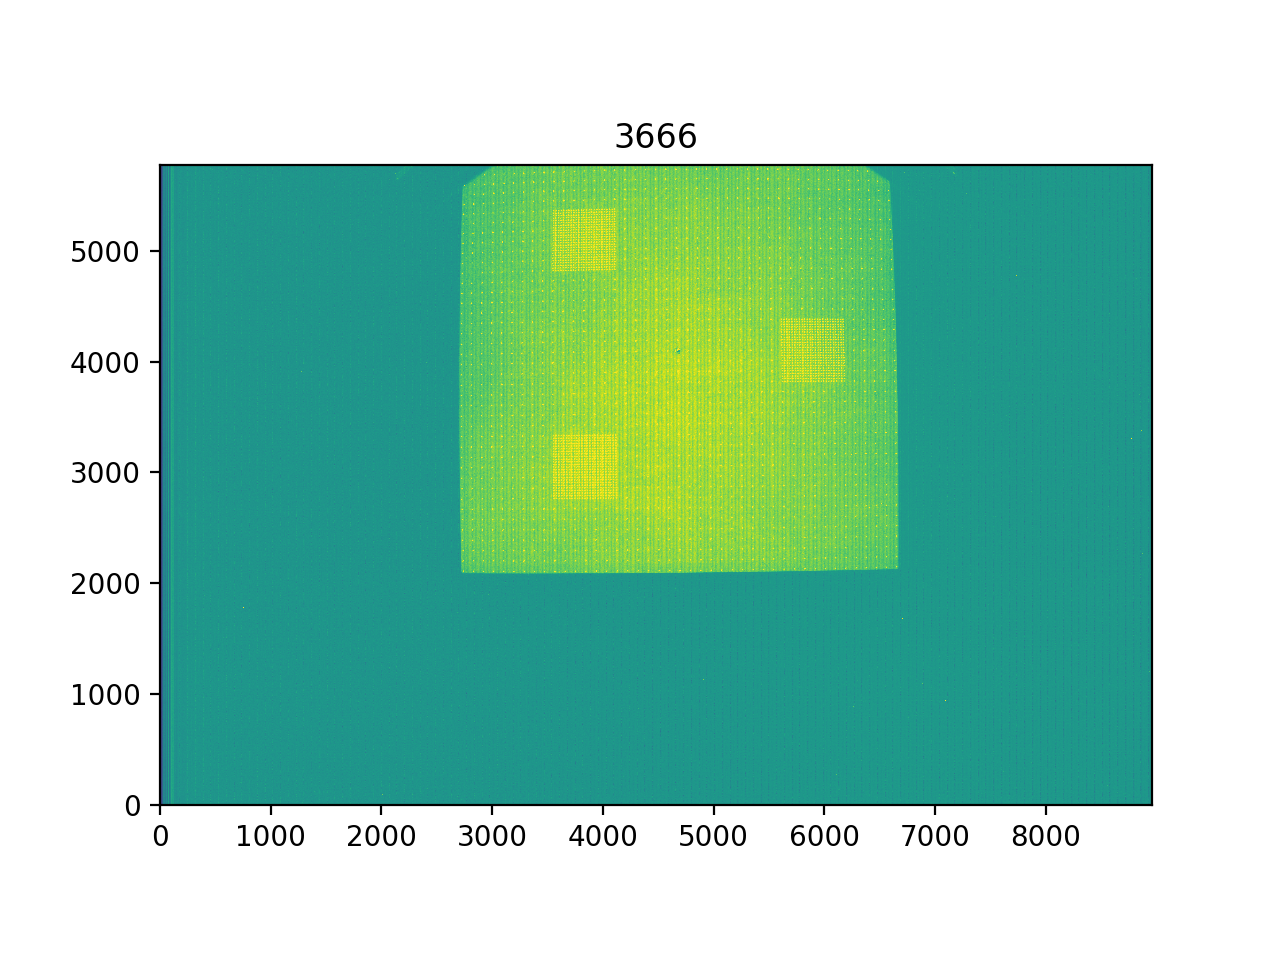

In [8]:

rms=image.std()
mn=image.mean()
vmin=mn-rms*2
vmax=mn+rms+20

fig,ax=plt.subplots()
ax.imshow(image,vmin=vmin,vmax=vmax,origin='lower')
ax.set_title(str(frameID))
fig.show()



### plot image + centroids

<IPython.core.display.Javascript object>


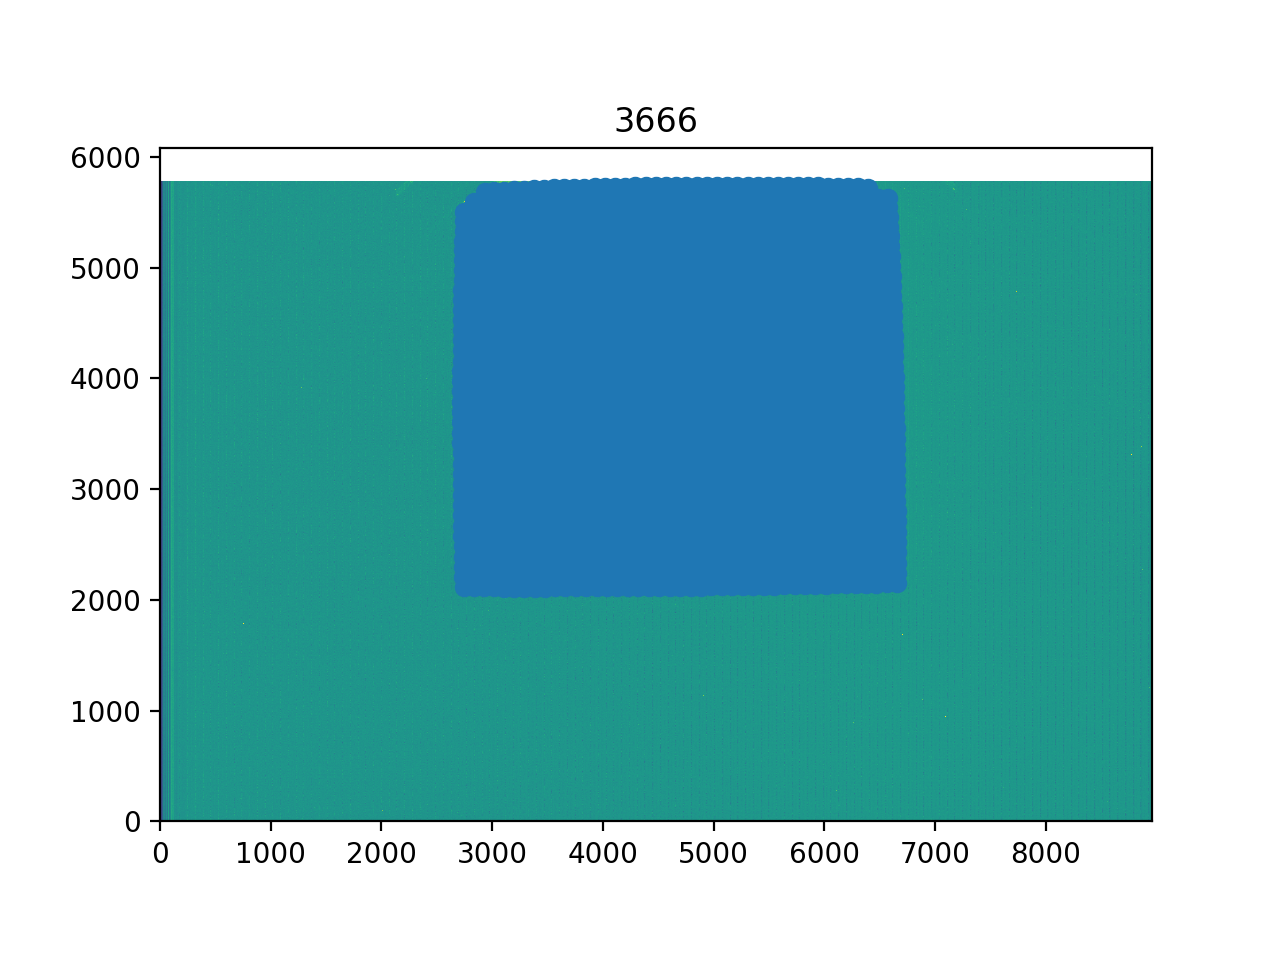

In [9]:
### plot image with centroids overlaid


rms=image.std()
mn=image.mean()
vmin=mn-rms*2
vmax=mn+rms+20

fig,ax=plt.subplots()
ax.imshow(image,vmin=vmin,vmax=vmax,origin='lower')
ax.set_title(str(frameID))
ax.scatter(x,y)
fig.show()




### plot image statistics


### check region used for threshold 

<IPython.core.display.Javascript object>


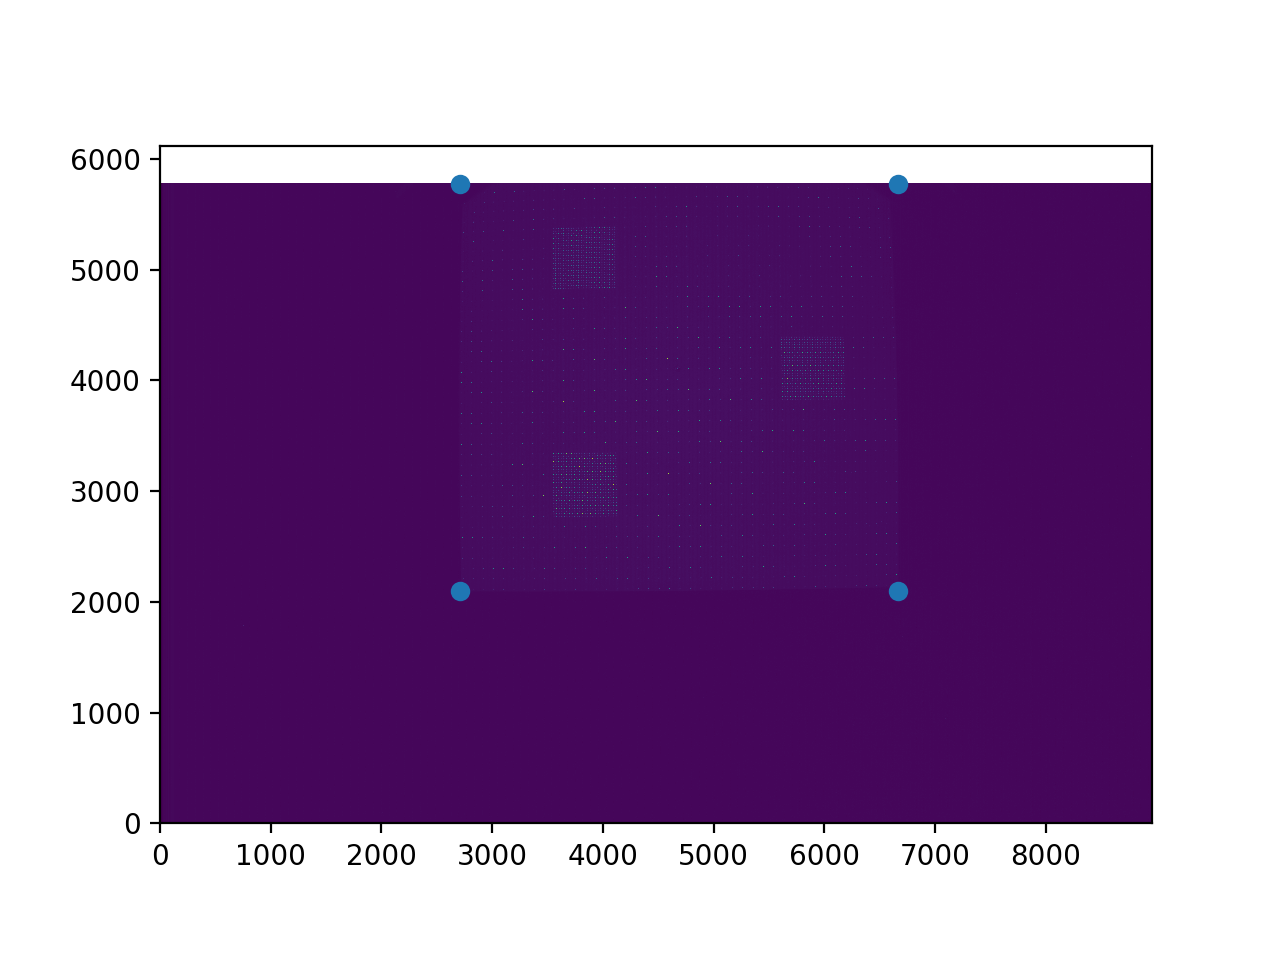

In [12]:
reload(visplot)
visplot.checkThreshold(image,xrange,yrange)

### Backup Thresholding routine

In [ ]:

#set xrange and yrange to the minimum and maximum values of the thresholding reigon
xrange=[]
yrange=[]

a=mcs.getManualThresh(image,xrange,yrange,threshSigma)
findThresh=a.mean()+a.std()*findSigma
centThresh=a.mean()+a.std()*centSigma





In [34]:
fname="20190812_adj6"
from PIL import Image
im=Image.open(fname+".tiff")
im1=np.array(im)
from astropy.io import fits
fits.writeto(fname+".fits",im1)